In [2]:
!pip install pandas-profiling xgboost gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.9 MB/s eta

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder

In [4]:
!wget https://github.com/Refactory-Capstone-Project/Loan-default-prediction-challenge-/raw/main/Loan_Prediction.zip

--2024-04-26 09:38:59--  https://github.com/Refactory-Capstone-Project/Loan-default-prediction-challenge-/raw/main/Loan_Prediction.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Refactory-Capstone-Project/Loan-default-prediction-challenge-/main/Loan_Prediction.zip [following]
--2024-04-26 09:38:59--  https://raw.githubusercontent.com/Refactory-Capstone-Project/Loan-default-prediction-challenge-/main/Loan_Prediction.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1627991 (1.6M) [application/zip]
Saving to: ‘Loan_Prediction.zip’

Loan_Prediction.zip 100%[===================>]   1.55M  --.

In [5]:
!unzip /content/Loan_Prediction.zip

Archive:  /content/Loan_Prediction.zip
  inflating: SampleSubmission.csv    
  inflating: testdemographics.csv    
  inflating: testperf.csv            
  inflating: testprevloans.csv       
  inflating: traindemographics.csv   
  inflating: trainperf.csv           
  inflating: trainprevloans.csv      


# Demographic data (traindemographics.csv)

In [6]:
train_demo = pd.read_csv("/content/traindemographics.csv")
train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [7]:
train_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4346 entries, 0 to 4345
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4346 non-null   object 
 1   birthdate                   4346 non-null   object 
 2   bank_account_type           4346 non-null   object 
 3   longitude_gps               4346 non-null   float64
 4   latitude_gps                4346 non-null   float64
 5   bank_name_clients           4346 non-null   object 
 6   bank_branch_clients         51 non-null     object 
 7   employment_status_clients   3698 non-null   object 
 8   level_of_education_clients  587 non-null    object 
dtypes: float64(2), object(7)
memory usage: 305.7+ KB


In [8]:
train_demo.dtypes

customerid                     object
birthdate                      object
bank_account_type              object
longitude_gps                 float64
latitude_gps                  float64
bank_name_clients              object
bank_branch_clients            object
employment_status_clients      object
level_of_education_clients     object
dtype: object

In [9]:
train_demo[train_demo['customerid'].duplicated(keep=False)].sort_values('customerid')

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
1414,8a858e625c8d993a015c938f829f77ee,1988-12-20 00:00:00.000000,Savings,5.768333,5.561992,First Bank,NaN,Permanent,NaN
1928,8a858e625c8d993a015c938f829f77ee,1988-12-20 00:00:00.000000,Savings,5.768333,5.561992,First Bank,NaN,Permanent,NaN
445,8a858e6c5c88d145015c8b9627cd5a48,1979-09-30 00:00:00.000000,Savings,3.367008,6.497313,Sterling Bank,NaN,Permanent,NaN
1090,8a858e6c5c88d145015c8b9627cd5a48,1979-09-30 00:00:00.000000,Savings,3.367008,6.497313,Sterling Bank,NaN,Permanent,NaN
1996,8a858ec65cc6352b015cc64525ea0763,1985-01-30 00:00:00.000000,Savings,3.845728,7.411737,GT Bank,NaN,Permanent,NaN
1520,8a858ec65cc6352b015cc64525ea0763,1985-01-30 00:00:00.000000,Savings,3.845728,7.411737,GT Bank,NaN,Permanent,NaN
272,8a858edd57f790040157ffe9b6ed3fbb,1988-01-18 00:00:00.000000,Other,3.782563,7.171356,First Bank,NaN,Permanent,Secondary
517,8a858edd57f790040157ffe9b6ed3fbb,1988-01-18 00:00:00.000000,Other,3.782563,7.171356,First Bank,NaN,Permanent,Secondary
4126,8a858f1e5baffcc9015bb02b505f180d,1983-04-06 00:00:00.000000,Savings,6.969350,4.818535,GT Bank,NaN,Permanent,NaN
3021,8a858f1e5baffcc9015bb02b505f180d,1983-04-06 00:00:00.000000,Savings,6.969350,4.818535,GT Bank,NaN,Permanent,NaN


In [10]:
train_demo = train_demo.drop_duplicates(subset='customerid', keep='first', inplace=False)

In [11]:
train_demo['birthdate'] = pd.to_datetime(train_demo['birthdate'])

train_demo["birthdate_year"] = pd.to_datetime(train_demo["birthdate"]).dt.year
train_demo["birthdate_month"] = pd.to_datetime(train_demo["birthdate"]).dt.month
train_demo["birthdate_day"] = pd.to_datetime(train_demo["birthdate"]).dt.day
train_demo.dtypes

customerid                            object
birthdate                     datetime64[ns]
bank_account_type                     object
longitude_gps                        float64
latitude_gps                         float64
bank_name_clients                     object
bank_branch_clients                   object
employment_status_clients             object
level_of_education_clients            object
birthdate_year                         int32
birthdate_month                        int32
birthdate_day                          int32
dtype: object

In [12]:
train_demo['bank_account_type'].value_counts()

bank_account_type
Savings    3414
Other       864
Current      56
Name: count, dtype: int64

In [13]:
encoder = LabelEncoder()
train_demo['bank_account_type'] = encoder.fit_transform(train_demo['bank_account_type'])
train_demo[['bank_account_type']]

,bank_account_type
0,2
1,2
2,2
3,2
4,2
...,...
4341,1
4342,2
4343,2
4344,2


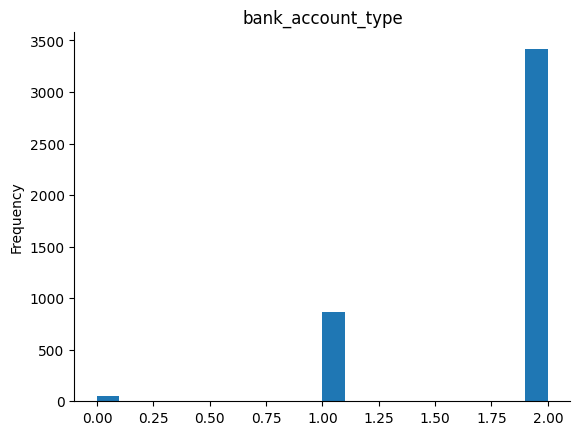

In [14]:

train_demo['bank_account_type'].plot(kind='hist', bins=20, title='bank_account_type')
plt.gca().spines[['top', 'right',]].set_visible(False)

Based off of the graph. We can see that Savings is represented by '2', Other is represented by '1' and Current is represented by 0

In [15]:
train_demo['longitude_gps'].describe()


count    4334.000000
mean        4.624000
std         7.194031
min      -118.247009
25%         3.354857
50%         3.591668
75%         6.543691
max       151.209290
Name: longitude_gps, dtype: float64

In [ ]:
train_demo['longitude_gps'] = train_demo['longitude_gps'].astype(float)
plt.boxplot(train_demo['longitude_gps'])
plt.title('Box Plot')
plt.ylabel('longitude_gps')
plt.show()

The Box plot shows the column has many outliers and they can be replaced with zero

In [17]:
train_demo["longitude_gps"] = train_demo["longitude_gps"] \
                                .where(train_demo["longitude_gps"] < 20)\
                                .where(train_demo["longitude_gps"] > -20)

In [ ]:
train_demo['latitude_gps'] = train_demo['latitude_gps'].astype(float)
plt.boxplot(train_demo['latitude_gps'])
plt.title('Box Plot')
plt.ylabel('latitude_gps')
plt.show()

In [19]:
train_demo["latitude_gps"] = train_demo["latitude_gps"] \
                                .where(train_demo["latitude_gps"] < 20)\
                                .where(train_demo["latitude_gps"] > -20)

In [ ]:
train_demo['bank_branch_clients'].info()

In [21]:
train_demo.drop(columns=['bank_branch_clients'], inplace=True)

In [ ]:
train_demo['employment_status_clients'].isnull().value_counts()

There are 648 null values however dropping them will get rid of important data. The null values can be replaced by "Unknown"

In [ ]:
train_demo["employment_status_clients"]= train_demo["employment_status_clients"].fillna("Unknown")
train_demo["employment_status_clients"].value_counts()

# Performance data (trainperf.csv)

This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict if whether this loan would default given all previous loans and demographics of a customer

In [24]:
train_perf = pd.read_csv('/content/trainperf.csv')
train_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,Good


In [25]:
train_perf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   customerid     4368 non-null   object 
 1   systemloanid   4368 non-null   int64  
 2   loannumber     4368 non-null   int64  
 3   approveddate   4368 non-null   object 
 4   creationdate   4368 non-null   object 
 5   loanamount     4368 non-null   float64
 6   totaldue       4368 non-null   float64
 7   termdays       4368 non-null   int64  
 8   referredby     587 non-null    object 
 9   good_bad_flag  4368 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 341.4+ KB


In [29]:
train_perf['customerid'].duplicated().sum()

0

In [32]:
train_perf['approveddate'] = pd.to_datetime(train_perf['approveddate'])

train_perf.dtypes

customerid               object
systemloanid              int64
loannumber                int64
approveddate     datetime64[ns]
creationdate             object
loanamount              float64
totaldue                float64
termdays                  int64
referredby               object
good_bad_flag            object
dtype: object

# Previous loans data (trainprevloans.csv)

This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

In [ ]:
train_prevloans = pd.read_csv('/content/trainprevloans.csv')
train_prevloans.head()